C:\Users\apicn\AppData\Local\Temp\ipykernel_31336\2892713562.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed



Datos descargados y medias móviles calculadas:
Price           Close       High        Low       Open     Volume  SMA_short  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2020-01-02  72.620842  72.681289  71.373218  71.627092  135480400  72.620842   
2020-01-03  71.914810  72.676439  71.689950  71.847110  146322800  72.267826   
2020-01-06  72.487839  72.526526  70.783241  71.034702  118387200  72.341164   
2020-01-07  72.146935  72.753816  71.926907  72.497522  108872000  72.292606   
2020-01-08  73.307518  73.609752  71.849540  71.849540  132079200  72.495589   

Price        SMA_long  
Ticker                 
Date                   
2020-01-02  72.620842  
2020-01-03  72.267826  
2020-01-06  72.341164  
2020-01-07  72.292606  
2020-01-08  72.495589  
Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL  

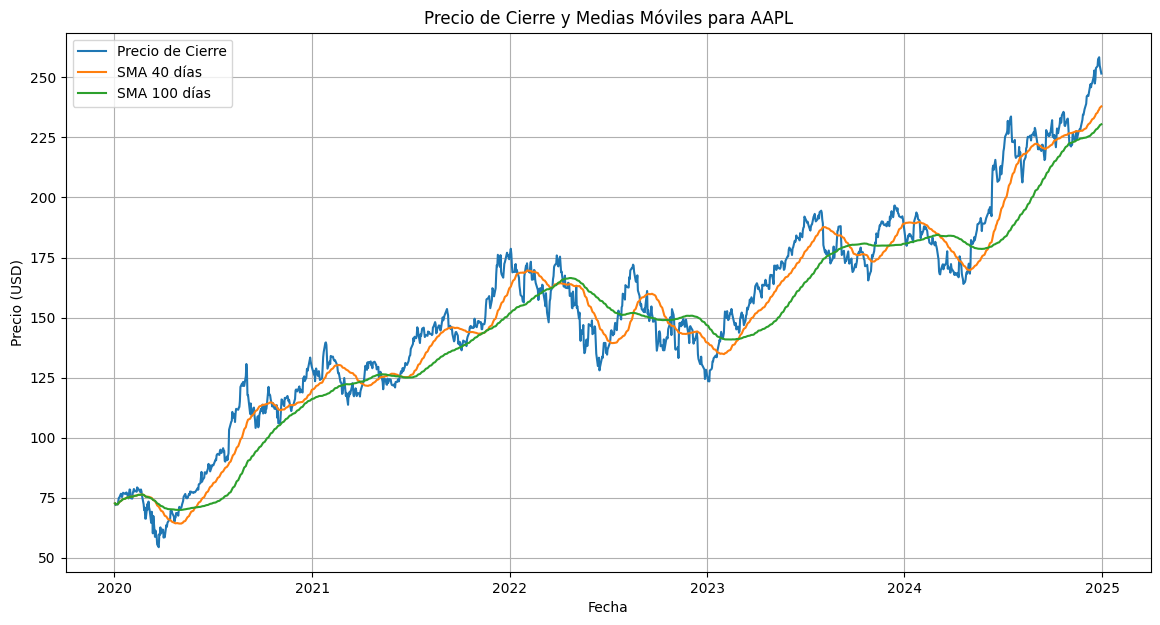

In [12]:
# Importar librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Obtención de Datos y Definición de la Estrategia

# Descargar datos históricos para Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')

# Definir los periodos para las medias móviles
short_window = 40  # Media móvil rápida (ej. 40 días)
long_window = 100 # Media móvil lenta (ej. 100 días)

# Calcular las medias móviles
data['SMA_short'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['SMA_long'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Mostrar los primeros y últimos datos para verificar
print("Datos descargados y medias móviles calculadas:")
print(data.head())
print(data.tail())

# Visualizar los precios y las medias móviles
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre')
plt.plot(data['SMA_short'], label=f'SMA {short_window} días')
plt.plot(data['SMA_long'], label=f'SMA {long_window} días')
plt.title(f'Precio de Cierre y Medias Móviles para {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Generación de Señales de Trading

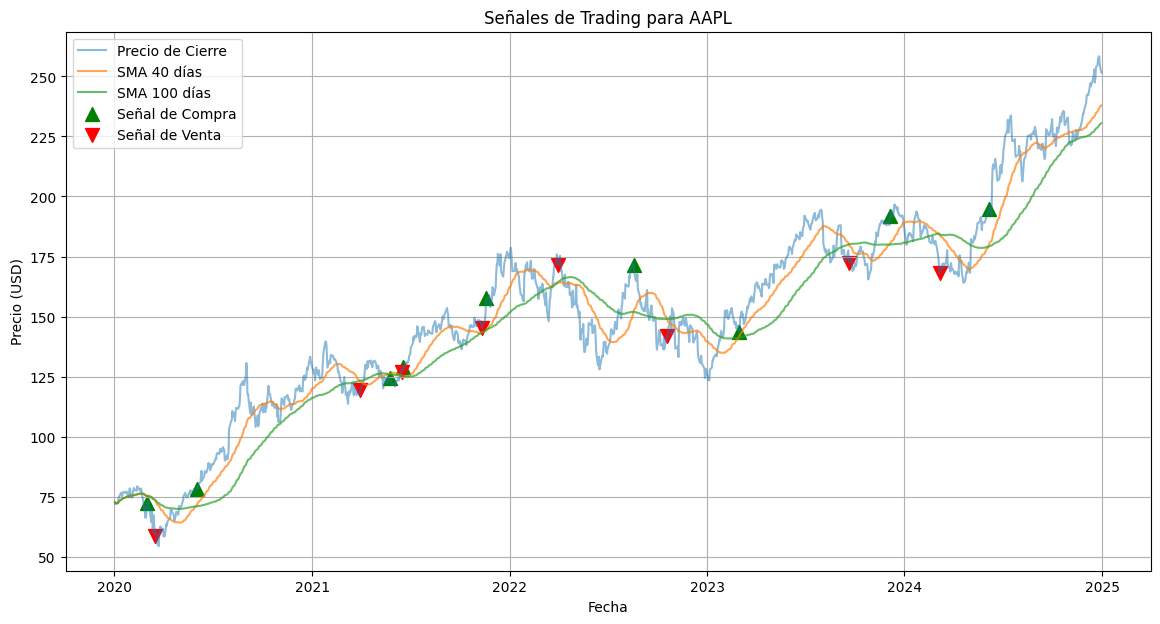


Señales de Compra:
Price            Close        High         Low        Open     Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL   
Date                                                                    
2020-03-02   72.419945   73.057356   67.308548   68.413715  341397200   
2020-06-01   78.215111   78.336619   77.087507   77.218738   80791200   
2021-05-24  124.382469  125.204513  123.247275  123.315778   63092900   
2021-06-17  128.972168  129.715928  126.877924  127.024726   96721700   
2021-11-19  157.582321  158.043635  153.636625  154.735917  117305600   

Price        SMA_short    SMA_long Signal Position  
Ticker                                              
Date                                                
2020-03-02   75.404784   75.336883      1      1.0  
2020-06-01   71.311553   70.967705      1      1.0  
2021-05-24  126.177284  125.968729      1      1.0  
2021-06-17  125.291791  125.234709      1      1.0  
2021-11-19  144.649278  

In [13]:
# Crear una nueva columna para las señales
data['Signal'] = 0 # 1 para compra, -1 para venta, 0 para mantener

# Generar la señal de compra (cruce de SMA corta sobre larga)
data['Signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)

# Generar la señal de venta (cruce de SMA corta bajo larga)
data['Position'] = data['Signal'].diff()

# Filtrar las señales de compra y venta reales
buy_signals = data[data['Position'] == 1]
sell_signals = data[data['Position'] == -1]

# Visualizar las señales en el gráfico
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Precio de Cierre', alpha=0.5)
plt.plot(data['SMA_short'], label=f'SMA {short_window} días', alpha=0.7)
plt.plot(data['SMA_long'], label=f'SMA {long_window} días', alpha=0.7)
plt.scatter(buy_signals.index, buy_signals['Close'], label='Señal de Compra', marker='^', color='green', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Señal de Venta', marker='v', color='red', s=100)
plt.title(f'Señales de Trading para {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

print("\nSeñales de Compra:")
print(buy_signals.head())
print("\nSeñales de Venta:")
print(sell_signals.head())

# Motor de Backtesting

In [14]:
# Configuración inicial del portafolio
initial_capital = 100000.0
cash = initial_capital
position = 0      # 0 para no tener posición, 1 para tenerla
num_shares = 0

# Usaremos listas para guardar los valores de cada día y construir el DataFrame al final
portfolio_cash = [initial_capital]
portfolio_holdings = [0.0]
portfolio_total = [initial_capital]

holdings_value = 0.0  # <-- Añade esta línea antes del bucle

# Iteramos a partir del segundo día
for i in range(1, len(data)):
    current_price = data['Close'].iloc[i].item()

    # Lógica de Compra: señal de compra (1) y no tenemos posición
    if data['Position'].iloc[i] == 1 and position == 0:
        position = 1
        num_shares = cash / current_price
        holdings_value = num_shares * current_price
        cash = 0
        print(f"COMPRA: {data.index[i].date()} | Precio: {current_price:.2f} | Acciones: {num_shares:.2f}")

    # Lógica de Venta: señal de venta (-1) y sí tenemos posición
    elif data['Position'].iloc[i] == -1 and position == 1:
        position = 0
        cash += num_shares * current_price
        holdings_value = 0
        num_shares = 0
        print(f"VENTA:  {data.index[i].date()} | Precio: {current_price:.2f}")

    # Si mantenemos la posición, actualizamos el valor de nuestras acciones
    if position == 1:
        holdings_value = num_shares * current_price
    elif position == 0:
        holdings_value = 0  # <-- Añade esto para asegurar que holdings_value siempre esté definido

    # Guardamos los valores del día en las listas
    portfolio_cash.append(cash)
    portfolio_holdings.append(holdings_value)
    portfolio_total.append(cash + holdings_value)

# Creación del DataFrame del portafolio al final del bucle
portfolio = pd.DataFrame({
    'cash': portfolio_cash,
    'holdings': portfolio_holdings,
    'total': portfolio_total
}, index=data.index)

# Calculamos los retornos diarios del portafolio
portfolio['returns'] = portfolio['total'].pct_change()
 

COMPRA: 2020-03-02 | Precio: 72.42 | Acciones: 1380.84
VENTA:  2020-03-16 | Precio: 58.70
COMPRA: 2020-06-01 | Precio: 78.22 | Acciones: 1036.35

VENTA:  2020-03-16 | Precio: 58.70
COMPRA: 2020-06-01 | Precio: 78.22 | Acciones: 1036.35
VENTA:  2021-03-31 | Precio: 119.34
COMPRA: 2021-05-24 | Precio: 124.38 | Acciones: 994.30
VENTA:  2021-06-15 | Precio: 126.87
COMPRA: 2021-06-17 | Precio: 128.97 | Acciones: 978.08
VENTA:  2021-03-31 | Precio: 119.34
COMPRA: 2021-05-24 | Precio: 124.38 | Acciones: 994.30
VENTA:  2021-06-15 | Precio: 126.87
COMPRA: 2021-06-17 | Precio: 128.97 | Acciones: 978.08
VENTA:  2021-11-11 | Precio: 145.14
COMPRA: 2021-11-19 | Precio: 157.58 | Acciones: 900.83
VENTA:  2022-03-31 | Precio: 171.60
VENTA:  2021-11-11 | Precio: 145.14
COMPRA: 2021-11-19 | Precio: 157.58 | Acciones: 900.83
VENTA:  2022-03-31 | Precio: 171.60
COMPRA: 2022-08-18 | Precio: 171.64 | Acciones: 900.64
VENTA:  2022-10-19 | Precio: 141.79
COMPRA: 2022-08-18 | Precio: 171.64 | Acciones: 900.64
